# Summary

* We save the video as frames.
* We train tiny models on the frames classifying them between 'fight' and 'non-fight'. Those will have high accuracy, indicating the presence of easily-detectable spurious correlations, probably brightness.
* We add color augmentations, and we notice that those tiny models do not reach the same performance on them. While it does not preclude clever Hans effects, it somewhat reduces the risk.

In [1]:
%load_ext autoreload
%autoreload 2

In [9]:
import pandas as pd

from fight_classifier import DATASET_DIR, PROJECT_DIR

frames_dir = DATASET_DIR / 'raw_frames/'
videos_dir = DATASET_DIR / 'Peliculas/'

videos_df = pd.read_csv(videos_dir / 'videos.csv')
videos_df

,video_path,is_fight,coarse_category,fine_category
0,Peliculas/fights/newfi1.avi,True,boxing,boxing_a
1,Peliculas/fights/newfi3.avi,True,boxing,boxing_a
2,Peliculas/fights/newfi4.avi,True,boxing,boxing_a
3,Peliculas/fights/newfi5.avi,True,boxing,boxing_a
4,Peliculas/fights/newfi6.avi,True,boxing,boxing_a
...,...,...,...,...
192,Peliculas/noFights/96.mpg,False,street_walking,street_c
193,Peliculas/noFights/97.mpg,False,wall,wall_j
194,Peliculas/noFights/98.mpg,False,wall,wall_j
195,Peliculas/noFights/99.mpg,False,wall,wall_j


In [10]:
from fight_classifier.data.video_to_images import (
    save_videos_dataset_as_frames)

# Save the videos to images
frames_df = save_videos_dataset_as_frames(
    videos_df=videos_df,
    videos_dir=DATASET_DIR,
    frames_dir=frames_dir
)


## Evidence of clever-hans

First, we do not apply any color augmentation. And we train a 1-layer (a 3x3 convolution) network on it. By overlaying the prediction of "fight" with the images, we can see the model learns to predict "fight" for dark patches and "non-fight" for light patches.

<table>
    <tr>
        <td><img src="media/hans_lay1_noaug/hans_lay1_noaug_ex1.png" width="300"/></td>
        <td><img src="media/hans_lay1_noaug/hans_lay1_noaug_ex2.png" width="300"/></td>
        <td><img src="media/hans_lay1_noaug/hans_lay1_noaug_ex3.png" width="300"/></td>
    </tr>
</table>

And, because of the large difference in average brightness between fight videos and non-fight videos, it is enough to achieve good accuracy. Note that the results below are on the validation dataset. Because those correlations happen throughout the dataset.

<table>
    <tr>
        <td><img src="media/hans_lay1_noaug/hans_lay1_noaug_cm.png" width="300"/></td>
        <td><img src="media/hans_lay1_noaug/hans_lay1_noaug_curve.png" width="300"/></td>
    </tr>
</table>

In [21]:
import pytorch_lightning as pl
from torchvision.models import MobileNet_V3_Large_Weights

from fight_classifier.data.image_dataset import ImageDataModule
from fight_classifier.model.hans_model import SmallCnnImageClassifier
from fight_classifier.torch_module.image_classifier import \
    ImageClassifierModule

BATCH_SIZE = 40
SPLIT_COHERENCE_COL = 'fine_category'

frames_df = pd.read_csv(str(frames_dir / 'frames.csv'))

# We base our pre-processing on Mobilenet because it's the
# base of the model we will train in the next notebook.
base_model_weights = MobileNet_V3_Large_Weights.DEFAULT
preprocess = base_model_weights.transforms()
preprocess_kwargs = {
    'resize_size': preprocess.resize_size[0],
    'crop_size': preprocess.crop_size[0],
    'mean': preprocess.mean,
    'std': preprocess.std,
}

trainer = pl.Trainer(
    default_root_dir=str(PROJECT_DIR),
    limit_val_batches=300,
    max_epochs=5,
)


image_data_module = ImageDataModule(
    image_df=frames_df,
    batch_size=BATCH_SIZE,
    preprocess_kwargs=preprocess_kwargs,
    split_coherence_col=SPLIT_COHERENCE_COL,
    image_augmentation=False)
classifier = SmallCnnImageClassifier(n_layers=1, n_classes=2)
classif_module = ImageClassifierModule(classifier=classifier)

trainer.fit(
    model=classif_module,
    datamodule=image_data_module)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/matthieu/aviva/hiring-challenge/venv/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `PrecisionRecallCurve` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)

   | Name                   | Type                    | Params
--------------------------------------------------------------------
0  | classifier             | SmallCnnImageClassifier | 1.2 K 
1  | train_precision        | Precision               | 0     
2  | train_recall           | Recall                  | 0     
3  | train_f1               | F1Score                 | 0     
4  | train_pr_curve         | PrecisionRecallCurve    | 0     
5  | train_confusion_matrix | ConfusionMatrix         | 0     
6  | val_precision          | Precision         

Sanity Checking: 0it [00:00, ?it/s]

/home/matthieu/aviva/hiring-challenge/fight_classifier/fight_classifier/visualization/metrics.py:30: RuntimeWarning: invalid value encountered in divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


# Augmenting the dataset

We experimented with brightness and contrast augmentation, of increasing magnitudes. However, the 1-layer network kept achieving decent performance. Which is why we also added a layer inverting the colors (image = 1.0 - image) with 50% probability. By definition, this will give a dataset-average of 0.5 for every channel.

We can observe a random sample of the augmented dataset. The colors are strange but, as humans, we can still recognize whether there is a fight or not.

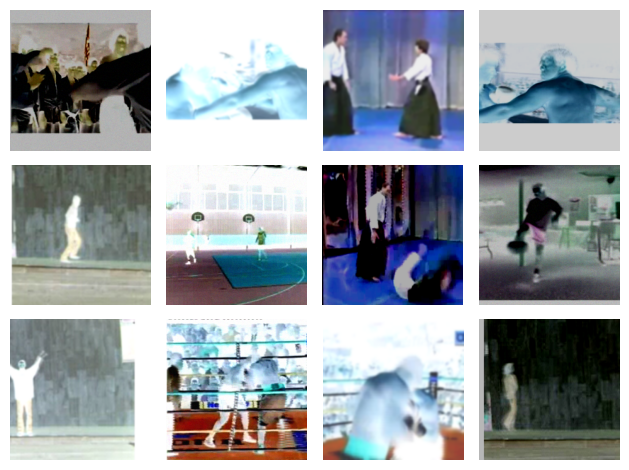

In [39]:
import matplotlib.pyplot as plt

from fight_classifier.visualization import imshow_chw

augmented_image_module = ImageDataModule(
    image_df=frames_df,
    batch_size=BATCH_SIZE,
    preprocess_kwargs=preprocess_kwargs,
    split_coherence_col=SPLIT_COHERENCE_COL,
    image_augmentation=True)
augmented_image_module.setup()

fig, axes = plt.subplots(nrows=3, ncols=4)
for i, batch in enumerate(augmented_image_module.train_dataloader()):
    if i >= 12:
        break
    augmented_image = batch['image_augmented'][0]
    axes[i%3][i//3].set_axis_off()
    imshow_chw(augmented_image, ax=axes[i%3][i//3])
plt.tight_layout()


# Testing the new dataset

We can verify that, after color augmentation, the 1-layer network is not able to be better than chance.

<div>
    <img src="media/hans_lay1_aug/hans_lay1_aug_curve.png" width="300"/>
</div>

In [41]:
trainer = pl.Trainer(
    default_root_dir=str(PROJECT_DIR),
    limit_val_batches=300,
    max_epochs=5,
)

classifier = SmallCnnImageClassifier(n_layers=1, n_classes=2)
classif_module = ImageClassifierModule(classifier=classifier)

trainer.fit(
    model=classif_module,
    datamodule=augmented_image_module)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/matthieu/aviva/hiring-challenge/venv/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `PrecisionRecallCurve` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)

   | Name                   | Type                    | Params
--------------------------------------------------------------------
0  | classifier             | SmallCnnImageClassifier | 1.2 K 
1  | train_precision        | Precision               | 0     
2  | train_recall           | Recall                  | 0     
3  | train_f1               | F1Score                 | 0     
4  | train_pr_curve         | PrecisionRecallCurve    | 0     
5  | train_confusion_matrix | ConfusionMatrix         | 0     
6  | val_precision          | Precision         

Sanity Checking: 0it [00:00, ?it/s]

/home/matthieu/aviva/hiring-challenge/fight_classifier/fight_classifier/visualization/metrics.py:30: RuntimeWarning: invalid value encountered in divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
